# Математические пакеты. Лабораторная работа №2

Цель работы – примененить дискретное преобразование Фурье,
используя библиотеки Python, для анализа речевых сигналов.

## Задачи
1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса
3. Построить сонограмму по записи своего голоса.

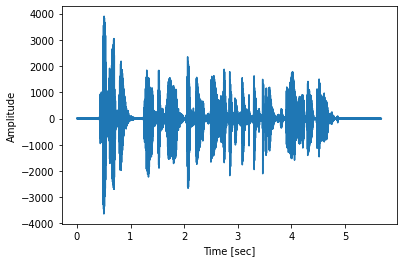

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import spectrogram
from scipy.io.wavfile import write, read
import numpy as np
import more_itertools as mit

fd, signal = read("audio.wav", "r")
time = np.linspace(0, len(signal) / fd, num=len(signal))
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.plot(time, signal)
plt.show()
ipd.Audio('audio.wav')

### Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.

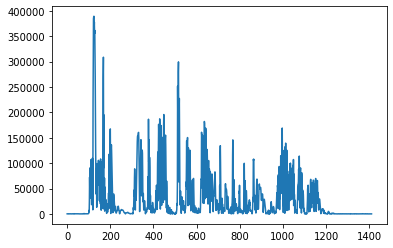

In [9]:
DTF_resolution = 512
spectral_resolution = round(fd/DTF_resolution)
overlap = 0.25/2

def DFT_slow(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

intervals = list(mit.windowed(signal, n=DTF_resolution, step=int(overlap*DTF_resolution)))
intervals[-1] = [i for i in intervals[-1] if i] # cleanup
intervals = [i*np.hamming(len(i)) for i in intervals] # hamming part

DTF_intervals = [DFT_slow(i) for i in intervals]

amplitude_spec = [sum([j**2 for j in i[:int(len(i)/2)]])**0.5 for i in DTF_intervals]
amplitude_spec_real = np.array([i.real for i in amplitude_spec])

plt.plot(amplitude_spec_real)
plt.show()

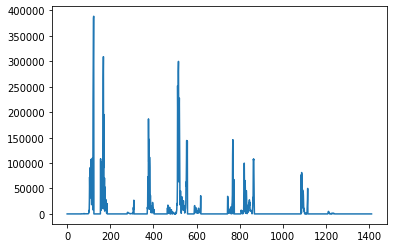

In [25]:
F0 = []
amp_sp = amplitude_spec
spec_res = spectral_resolution
chunks = [amp_sp[i:i+spec_res] for i in range(0, len(amp_sp), spec_res)]

significance_coef = 4

for chunk in chunks:
    segment = np.array(chunk)
    if segment.max() > significance_coef*segment.mean(): # significant change from mean           
        F0 += segment.tolist()
    else:
        F0 += [0] * len(segment)

plt.plot(F0)
plt.show()

### Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса


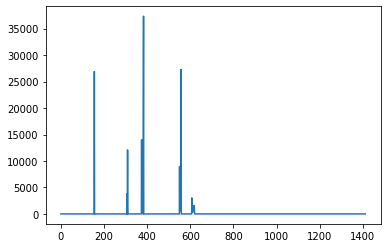

In [47]:
def secondary_freq(F0, freq_number):
    F = []
    k = freq_number + 1
    for i in range (len(F0)):
        if k*i+1 > len(F0):
            F.append(0)
        else:
            part_max = max(F0[k*i-1 : k*i+1], default=0)
            if F0[i] <= (2**freq_number)*part_max:           
                F.append(0)
            else:
                F.append(part_max)
    return F

F1 = secondary_freq(F0, 1)
plt.plot(F1)
plt.show()

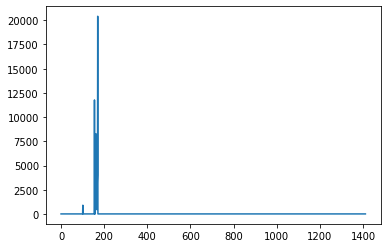

In [48]:
F2 = secondary_freq(F0, 2)

plt.plot(F2)
plt.show()

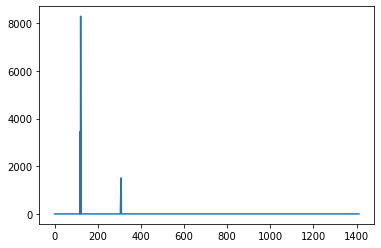

In [49]:
F3 = secondary_freq(F0, 3)

plt.plot(F3)
plt.show()

### Построить сонограмму по записи своего голоса.

In [69]:
matrix_amp = []
for i in [amplitude_spec[k:k + spectral_resolution] for k in range(len(amplitude_spec) -17)[::spectral_resolution]]:
    matrix_amp.append(i)

import plotly.express as px

fig = px.imshow(np.transpose(matrix_amp))
fig.show()